In [1]:
import gc
import time
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

from tensorflow.python.client import device_lib


from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

import mne

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Flatten


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [3]:
tf.test.gpu_device_name()

''

### Loading edf

In [4]:
file = "..\dataverse_files\h01.edf"
edfs_path = "..\dataverse_files"
manifest_path = "..\dataverse_files\MANIFEST.txt"

In [5]:
def load_patients_data(edfs_path):
    raw_patients_data = []
    
    edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]
    
    for file_name in edfs_file_names:
        path = edfs_path + '\\' + file_name 
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return raw_patients_data

In [6]:
raw_patients_data = load_patients_data(edfs_path)

### Filtered EEG signals segmentation

In [7]:
def get_label(edf):
    patient_edf_file_name = edf.filenames[0].split('\\')[-1]
    isSick = patient_edf_file_name.lower().startswith('s')
    return int(isSick == True) # 1 - is sick, 0 is healthy

In [8]:
def get_min_max_duration_for_classes(print_durations=False):
    min_SZ_negative_duration = float("inf") # healthy
    min_SZ_positive_duration = float("inf") # sick

    max_SZ_negative_duration = 0 # healthy
    max_SZ_positive_duration = 0 # sick

    for edf in raw_patients_data:
        duration = edf.times[-1]

        if(get_label(edf) == 0):
            min_SZ_negative_duration = duration if duration < min_SZ_negative_duration else min_SZ_negative_duration
            max_SZ_negative_duration = duration if duration > max_SZ_negative_duration else max_SZ_negative_duration
        else:
            min_SZ_positive_duration = duration if duration < min_SZ_positive_duration else min_SZ_positive_duration
            max_SZ_positive_duration = duration if duration > max_SZ_positive_duration else max_SZ_positive_duration


    print('SZ_negative: min =', min_SZ_negative_duration, ', max =', max_SZ_negative_duration)
    print('SZ_positive: min =', min_SZ_positive_duration, ', max =', max_SZ_positive_duration)
    
    return min_SZ_negative_duration, min_SZ_positive_duration, max_SZ_negative_duration, max_SZ_positive_duration

In [9]:
def crop_raw_data_to_equalize_duration_per_class():
    print("Duration per class before cropping: ")
    min_dur_neg, min_dur_pos, *_ = get_min_max_duration_for_classes(True)
    
    for edf in raw_patients_data:
        duration = edf.times[-1]

        if(get_label(edf) == 0):
            if(duration > min_dur_neg):
                edf.crop(tmin=0, tmax=min_dur_neg, include_tmax=True)
        else:
            if(duration > min_dur_pos):
                edf.crop(tmin=0, tmax=min_dur_pos, include_tmax=True)
                
    print("\nDuration per class after cropping: ")

    get_min_max_duration_for_classes(True)


In [10]:
def print_info(epochs_num_per_patient, labels):
    print('\nEpochs number per patient: ', epochs_num_per_patient)
    
    class_SZ_positive = sum(labels) 
    class_SZ_negative= len(labels)-sum(labels)

    print('\nnegative: ', class_SZ_positive)
    print('positive: ', class_SZ_negative)

In [11]:
def transform_patients_data_into_X_y_sets(patients_data, segment_duration=5.0, info=True):
    epochs_per_patient = []
    labels = []
    
    epochs_num_per_patient = []
    for edf in raw_patients_data:
        epochs = mne.make_fixed_length_epochs(edf, duration=segment_duration, preload=True, verbose=False)
        epochs_per_patient.append(epochs)
        epochs_num_per_patient.append(len(epochs))
        
        label = get_label(edf)
        labels.extend([label for epoch in epochs])
    
    epochs = mne.concatenate_epochs(epochs_per_patient)

    if info:
        print_info(epochs_num_per_patient, labels)
        
    del epochs_num_per_patient
    gc.collect()
    
    return (epochs, np.array(labels)) # (X, y)

In [12]:
# crop_raw_data_to_equalize_duration_per_class()

In [13]:
X, y = transform_patients_data_into_X_y_sets(patients_data=raw_patients_data, segment_duration=5.0)

Not setting metadata
5771 matching events found
No baseline correction applied
0 bad epochs dropped

Epochs number per patient:  [185, 182, 182, 185, 189, 186, 182, 182, 181, 223, 183, 180, 193, 173, 169, 229, 192, 241, 178, 148, 269, 182, 237, 170, 272, 217, 227, 434]

negative:  3165
positive:  2606


In [14]:
del raw_patients_data
gc.collect()

0

In [15]:
print(len(y))
print(len(X))
print(X[0].get_data().shape)

5771
5771
(1, 19, 1250)


In [16]:
X.to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


In [17]:
X[0].to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


In [18]:
### Data preparation

np.set_printoptions(precision=50)

x_data = X.get_data()
print('x_data shape:', x_data.shape)

column_names = X[0].to_data_frame().columns
column_names = column_names[-19:]
print('column_names:', column_names)

epoch_num, channel_num, epoch_len = x_data.shape

x_data shape: (5771, 19, 1250)
column_names: Index(['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
       'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz'],
      dtype='object')


In [19]:
x_data = x_data.swapaxes(1, 2)
x_data.shape

(5771, 1250, 19)

In [20]:
input_shape = x_data[0].shape
input_shape

(1250, 19)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, shuffle=True, random_state=1)

In [22]:
validation_data_ratio = 0.2
input_shape = Input(shape=input_shape)
print('input_shape:', input_shape)
batch_size = 128
# n_steps = traingen.samples // BATCH_SIZE
# n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

input_shape: KerasTensor(type_spec=TensorSpec(shape=(None, 1250, 19), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [23]:
import random
rnd_seed = random.randint(0, 1000000)
print(rnd_seed)

138634


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

In [25]:
def CNN(input_shape, opt, fine_tune=False, chans=19, nb_classes=2, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout1D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout1D '
                         'or Dropout, passed as a string.')
    
    input1 = input_shape
    
    pooling_layer1_format = 'channels_first'
    pooling_layer2_format = 'channels_last'
   

    ##################################################################
    block1       = Conv1D(F1, (kernLength), padding = 'same',
                                  # input_shape = ( chans, samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = -1)(block1)
   
    block1       = Conv1D(5, (chans), padding='same',
                          use_bias = False )(block1)
    block1       = BatchNormalization(axis = -1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling1D(pool_size=(4),  name='apl1')(block1)
    block1       = dropoutType(dropoutRate)(block1)
 
    block2       = Conv1D(5, ( 16),
                                   use_bias = False, padding = 'same' )(block1)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('elu')(block2)
    #block2       = AveragePooling1D(pool_size=(3), name='apl2')(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    
    
    block2       = Conv1D(5, ( 16),
                                   use_bias = False, padding = 'same' )(block2)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('elu')(block2)
    block2       = dropoutType(dropoutRate)(block2)
 
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(1, name = 'dense',  kernel_constraint = max_norm(norm_rate))(flatten)
    
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    model = Model(inputs=input1, outputs=softmax)
    
    model.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [44]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [45]:
model = CNN(input_shape, opt, chans=19, fine_tune=0)

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1250, 19)]        0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1250, 8)           9728      
                                                                 
 batch_normalization_4 (Batc  (None, 1250, 8)          32        
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 1250, 5)           760       
                                                                 
 batch_normalization_5 (Batc  (None, 1250, 5)          20        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 1250, 5)           0   

In [47]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../vgg16/V1/weights/model.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           restore_best_weights=True,
                           mode='min')

In [48]:
history = model.fit(
    x=X_train, 
    y=y_train.reshape(-1,1),
    batch_size=32,
    validation_split=0.2,
    epochs=50, 
#     callbacks=[tl_checkpoint_1, early_stop],
    callbacks=[early_stop],
    verbose=1)

Epoch 1/50
116/116 [==============================] - 10s 78ms/step - loss: 0.5466 - accuracy: 0.6910 - val_loss: 0.6888 - val_accuracy: 0.5541
Epoch 2/50
116/116 [==============================] - 9s 77ms/step - loss: 0.3480 - accuracy: 0.8432 - val_loss: 0.8391 - val_accuracy: 0.5541
Epoch 3/50
116/116 [==============================] - 9s 77ms/step - loss: 0.2386 - accuracy: 0.9085 - val_loss: 0.6795 - val_accuracy: 0.5541
Epoch 4/50
116/116 [==============================] - 9s 76ms/step - loss: 0.1972 - accuracy: 0.9285 - val_loss: 0.8761 - val_accuracy: 0.4913
Epoch 5/50
116/116 [==============================] - 9s 76ms/step - loss: 0.1531 - accuracy: 0.9456 - val_loss: 1.8770 - val_accuracy: 0.4686
Epoch 6/50
116/116 [==============================] - 9s 80ms/step - loss: 0.1239 - accuracy: 0.9607 - val_loss: 2.1848 - val_accuracy: 0.5671
Epoch 7/50
116/116 [==============================] - 10s 87ms/step - loss: 0.1293 - accuracy: 0.9521 - val_loss: 0.2553 - val_accuracy: 0.96

In [49]:
# model.save('../vgg16/V1/model/')

In [50]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [51]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


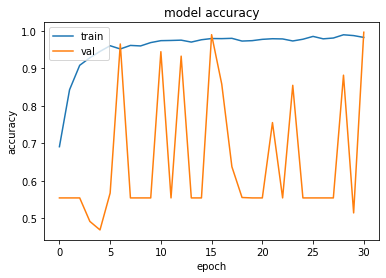

In [52]:
plot_accuracy(history)

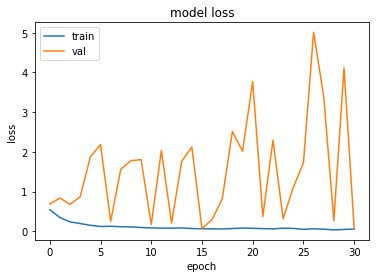

In [53]:
plot_loss(history)

In [54]:
predictions = model.predict(X_test, verbose=0)


In [55]:
predictions = np.array([0 if x < 0.5 else 1 for x in predictions])

In [56]:
print(len(predictions))
print(len(y_test))

1155
1155


In [57]:
print(predictions[0:15])
print(y_test[0:15])

[1 1 0 0 1 0 0 0 0 1 0 1 1 0 1]
[1 1 0 0 1 0 0 0 0 1 0 1 1 0 1]


In [58]:
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9852813852813853


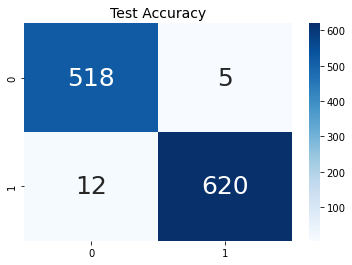

In [59]:
confusion_mtx = confusion_matrix(y_test, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
ax.set_title('Test Accuracy', size=14)
plt.show()

In [26]:
def CNN(input_shape, opt, fine_tune=False, chans=19, nb_classes=2, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout1D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout1D '
                         'or Dropout, passed as a string.')
    
    input1 = input_shape
    
    pooling_layer1_format = 'channels_first'
    pooling_layer2_format = 'channels_last'
   

    ##################################################################
    block1       = Conv1D(F1, (kernLength), padding = 'same',
                                  # input_shape = ( chans, samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = -1)(block1)
   
    block1       = Conv1D(5, (chans), padding='same',
                          use_bias = False )(block1)
    block1       = BatchNormalization(axis = -1)(block1)
    block1       = Activation('relu')(block1)
    block1       = AveragePooling1D(pool_size=(4),  name='apl1')(block1)
    block1       = dropoutType(dropoutRate)(block1)
 
    block2       = Conv1D(5, ( 16),
                                   use_bias = False, padding = 'same' )(block1)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('relu')(block2)
    #block2       = AveragePooling1D(pool_size=(3), name='apl2')(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    
    
    block2       = Conv1D(5, ( 16),
                                   use_bias = False, padding = 'same' )(block2)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('relu')(block2)
    block2       = dropoutType(dropoutRate)(block2)
 
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(1, name = 'dense',  kernel_constraint = max_norm(norm_rate))(flatten)
    
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    model = Model(inputs=input1, outputs=softmax)
    
    model.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [27]:
opt = keras.optimizers.Adam(learning_rate=0.0004)

In [28]:
model = CNN(input_shape, opt, chans=19, fine_tune=0)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1250, 19)]        0         
                                                                 
 conv1d (Conv1D)             (None, 1250, 8)           9728      
                                                                 
 batch_normalization (BatchN  (None, 1250, 8)          32        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 1250, 5)           760       
                                                                 
 batch_normalization_1 (Batc  (None, 1250, 5)          20        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 1250, 5)           0     

In [30]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../vgg16/V1/weights/model.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           restore_best_weights=True,
                           mode='min')

In [31]:
history = model.fit(
    x=X_train, 
    y=y_train.reshape(-1,1),
    batch_size=32,
    validation_split=0.2,
    epochs=50, 
#     callbacks=[tl_checkpoint_1, early_stop],
    callbacks=[early_stop],
    verbose=1)

Epoch 1/50
116/116 [==============================] - 10s 74ms/step - loss: 0.6359 - accuracy: 0.6024 - val_loss: 0.7024 - val_accuracy: 0.4459
Epoch 2/50
116/116 [==============================] - 10s 87ms/step - loss: 0.4824 - accuracy: 0.7709 - val_loss: 0.8269 - val_accuracy: 0.4459
Epoch 3/50
116/116 [==============================] - 10s 83ms/step - loss: 0.3789 - accuracy: 0.8264 - val_loss: 0.9433 - val_accuracy: 0.4459
Epoch 4/50
116/116 [==============================] - 9s 79ms/step - loss: 0.2872 - accuracy: 0.8889 - val_loss: 1.0203 - val_accuracy: 0.4502
Epoch 5/50
116/116 [==============================] - 10s 84ms/step - loss: 0.2098 - accuracy: 0.9315 - val_loss: 0.9379 - val_accuracy: 0.5509
Epoch 6/50
116/116 [==============================] - 9s 81ms/step - loss: 0.1765 - accuracy: 0.9426 - val_loss: 0.3387 - val_accuracy: 0.8366
Epoch 7/50
116/116 [==============================] - 10s 85ms/step - loss: 0.1574 - accuracy: 0.9537 - val_loss: 0.3797 - val_accuracy: 0

In [32]:
# model.save('../vgg16/V1/model/')

In [33]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [34]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


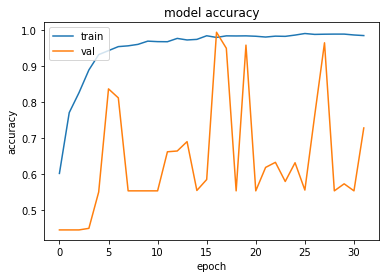

In [35]:
plot_accuracy(history)

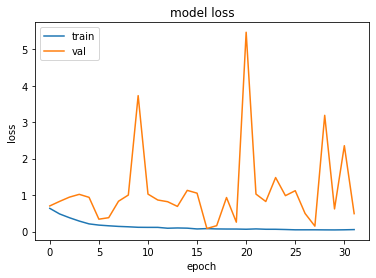

In [36]:
plot_loss(history)

In [37]:
predictions = model.predict(X_test, verbose=0)


In [38]:
predictions = np.array([0 if x < 0.5 else 1 for x in predictions])

In [39]:
print(len(predictions))
print(len(y_test))

1155
1155


In [40]:
print(predictions[0:15])
print(y_test[0:15])

[1 1 0 0 1 0 0 0 0 1 0 1 1 0 1]
[1 1 0 0 1 0 0 0 0 1 0 1 1 0 1]


In [41]:
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9904761904761905


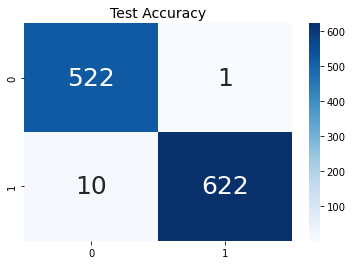

In [42]:
confusion_mtx = confusion_matrix(y_test, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
ax.set_title('Test Accuracy', size=14)
plt.show()

# VGG16

In [42]:
def create_model(input_shape, optimizer='adam', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    print(input_shape)
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    
    top_model = Flatten(name="flatten")(top_model)
            
    top_model = Dropout(0.6)(top_model)

    top_model = Dense(512, activation='relu', name="fc1", 
                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.L2(1e-4),
                      activity_regularizer=regularizers.L2(1e-5))(top_model)
    
    top_model = Dropout(0.7)(top_model)
    
    output_layer = Dense(1, activation='sigmoid', name="prediction")(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [43]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [44]:
model = create_model((1, 1250, 19), opt, fine_tune=0)

(1, 1250, 19)


ValueError: The input must have 3 channels; Received `input_shape=(1, 1250, 19)`

In [28]:
model.summary()

NameError: name 'model' is not defined

In [207]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../vgg16/V7/weights/model.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=15,
                           restore_best_weights=True,
                           mode='max', 
                           verbose=1)

In [208]:
history = model.fit(
    train_ds, 
    epochs=100, 
    validation_data=validation_ds, 
    #     callbacks=[tl_checkpoint_1, early_stop],
    callbacks=[early_stop],
    verbose=1)

Epoch 1/100
23/23 [==============================] - 132s 6s/step - loss: 5.0990 - accuracy: 0.7031 - val_loss: 0.9837 - val_accuracy: 0.7024
Epoch 2/100
23/23 [==============================] - 131s 6s/step - loss: 0.8036 - accuracy: 0.7830 - val_loss: 0.8120 - val_accuracy: 0.7771
Epoch 3/100
23/23 [==============================] - 131s 6s/step - loss: 0.6997 - accuracy: 0.8133 - val_loss: 0.7959 - val_accuracy: 0.7969
Epoch 4/100
23/23 [==============================] - 131s 6s/step - loss: 0.6752 - accuracy: 0.8178 - val_loss: 0.7780 - val_accuracy: 0.7928
Epoch 5/100
23/23 [==============================] - 131s 6s/step - loss: 0.6363 - accuracy: 0.8268 - val_loss: 0.7094 - val_accuracy: 0.7764
Epoch 6/100
23/23 [==============================] - 131s 6s/step - loss: 0.6234 - accuracy: 0.8317 - val_loss: 0.7097 - val_accuracy: 0.7691
Epoch 7/100
23/23 [==============================] - 131s 6s/step - loss: 0.6089 - accuracy: 0.8359 - val_loss: 0.6699 - val_accuracy: 0.8122
Epoch 

In [209]:
# model.save('../models/vgg16_std_norm_2DeRe_1DeSi/model/')

In [210]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [211]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


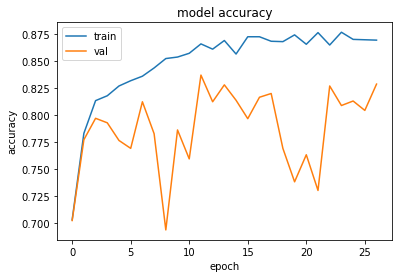

In [212]:
plot_accuracy(history)

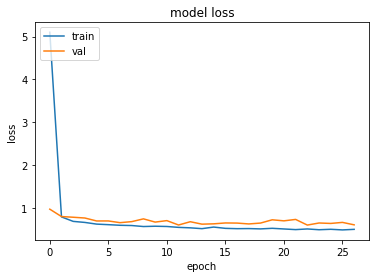

In [213]:
plot_loss(history)

In [214]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_ds:
    predictions = np.concatenate([predictions, model.predict(x, verbose=0).reshape(1,-1)[0]])
    labels = np.concatenate([labels, np.array(y[0])])

In [215]:
predictions = [0 if x < 0.5 else 1 for x in predictions]

In [216]:
print(predictions[0:15])
print(labels[0:15])

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]


In [217]:
print(len(predictions))
print(len(labels))

900
900


In [218]:
accuracy = accuracy_score(labels, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8377777777777777


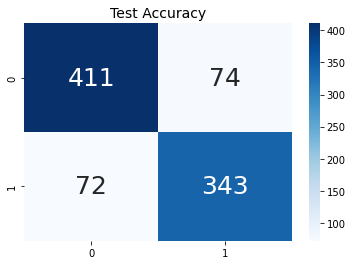

In [219]:
confusion_mtx = confusion_matrix(labels, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
ax.set_title('Test Accuracy', size=14)
plt.show()

## TESTS

In [31]:
X_train.shape


(3595, 19, 1250)

In [49]:
X_train[0]

array([[ 9.7884285256513177e-06,  1.4069772255623544e-05,
         1.2540720923490606e-05, ..., -7.0311361278110084e-06,
        -3.8201283303318380e-06, -5.1962745292514823e-06],
       [ 1.2999436323130489e-05,  1.6210444120609662e-05,
         1.5598823587756484e-05, ..., -1.2207410657058417e-06,
         1.9902667317733296e-06,  1.6844564653467419e-06],
       [ 1.2693626056703902e-05,  1.6974969786676128e-05,
         1.0705859324931081e-05, ..., -7.6427566606641846e-06,
        -5.0433693960381887e-06, -9.1493079927925389e-07],
       ...,
       [ 1.0552954191717786e-05,  1.1776195257424138e-05,
         9.0239028595848496e-06, ...,  6.1412053285368482e-07,
         3.2135077974796807e-06,  3.9780334635461497e-06],
       [ 1.0552954191717786e-05,  1.0552954191717786e-05,
         7.8006617938784972e-06, ..., -2.1381718649856051e-06,
        -1.5040513321278456e-07,  2.5000000005093171e-09],
       [ 2.1431718649866236e-06,  4.2838437299727378e-06,
         3.0606026642663871e-0

In [51]:
X_train[0].transpose().shape

(1250, 19)

In [28]:
X_train[0].shape

(19, 1250)

In [44]:
X_train.reshape(3595, 1250, 19)

array([[[ 9.7884285256513177e-06,  1.4069772255623544e-05,
          1.2540720923490606e-05, ...,  3.0606026642663871e-06,
         -1.6794564653457232e-06, -4.5846539963983070e-06],
        [-2.5968872646254864e-06, -2.2910769981988988e-06,
          5.6599899288923830e-06, ...,  1.0400049058504492e-05,
          1.2540720923490606e-05,  1.4069772255623544e-05],
        [ 1.2846531189917195e-05,  1.0552954191717786e-05,
          9.1768079927981415e-06, ...,  5.0483693960392076e-06,
          1.6844564653467419e-06, -1.3736461989191355e-06],
        ...,
        [ 9.1993079928027250e-07,  1.9902667317733296e-06,
          1.3786461989201540e-06, ...,  1.5540513321380320e-07,
          2.5000000005093171e-09,  1.0728359324935666e-06],
        [-1.5040513321278456e-07, -1.5040513321278456e-07,
         -1.9852667317723111e-06, ..., -6.1137053285312458e-06,
         -6.4195155949578330e-06, -8.1014720603040672e-06],
        [-9.4776182592237098e-06, -1.0395049058503473e-05,
         -9.6

In [33]:
X_train.transpose()[0].shape

(19, 3595)

In [53]:
X_train[0].transpose()

array([[ 9.7884285256513177e-06,  1.2999436323130489e-05,
         1.2693626056703902e-05, ...,  1.0552954191717786e-05,
         1.0552954191717786e-05,  2.1431718649866236e-06],
       [ 1.4069772255623544e-05,  1.6210444120609662e-05,
         1.6974969786676128e-05, ...,  1.1776195257424138e-05,
         1.0552954191717786e-05,  4.2838437299727378e-06],
       [ 1.2540720923490606e-05,  1.5598823587756484e-05,
         1.0705859324931081e-05, ...,  9.0239028595848496e-06,
         7.8006617938784972e-06,  3.0606026642663871e-06],
       ...,
       [-7.0311361278110084e-06, -1.2207410657058417e-06,
        -7.6427566606641846e-06, ...,  6.1412053285368482e-07,
        -2.1381718649856051e-06, -2.2910769981988988e-06],
       [-3.8201283303318380e-06,  1.9902667317733296e-06,
        -5.0433693960381887e-06, ...,  3.2135077974796807e-06,
        -1.5040513321278456e-07, -2.2910769981988988e-06],
       [-5.1962745292514823e-06,  1.6844564653467419e-06,
        -9.1493079927925389e-0

In [52]:
X_train.swapaxes(1, 2)

array([[[ 9.7884285256513177e-06,  1.2999436323130489e-05,
          1.2693626056703902e-05, ...,  1.0552954191717786e-05,
          1.0552954191717786e-05,  2.1431718649866236e-06],
        [ 1.4069772255623544e-05,  1.6210444120609662e-05,
          1.6974969786676128e-05, ...,  1.1776195257424138e-05,
          1.0552954191717786e-05,  4.2838437299727378e-06],
        [ 1.2540720923490606e-05,  1.5598823587756484e-05,
          1.0705859324931081e-05, ...,  9.0239028595848496e-06,
          7.8006617938784972e-06,  3.0606026642663871e-06],
        ...,
        [-7.0311361278110084e-06, -1.2207410657058417e-06,
         -7.6427566606641846e-06, ...,  6.1412053285368482e-07,
         -2.1381718649856051e-06, -2.2910769981988988e-06],
        [-3.8201283303318380e-06,  1.9902667317733296e-06,
         -5.0433693960381887e-06, ...,  3.2135077974796807e-06,
         -1.5040513321278456e-07, -2.2910769981988988e-06],
        [-5.1962745292514823e-06,  1.6844564653467419e-06,
         -9.1

In [54]:
X_train = X_train.swapaxes(1, 2).shape

(3595, 1250, 19)